# Model Validation and Filtering for High Performing Per Gene Models

### Exploratory Analysis and Model Performance Validation

In [ ]:
# load libraries
# The type: ignore is to ignore the missing modules in my development environment
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # type: ignore
import os
import shutil

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load and clean data for model predictions output

# load model predictions
new_depmap_expr_only = pd.read_csv("output_data/CCLE_expression_EN_21Q1_predictions.csv") # data available within the app MongoDB
real_depmap_21Q1 = pd.read_csv("data/Achilles_gene_effect_21Q1.csv") # data available at https://depmap.org/portal/download/
published_EN_predicted_depmap_21Q1 = pd.read_csv("data/published_DEPMAP_predicted_effect_expronly.csv") # data available through the publication https://www.nature.com/articles/s41586-020-2536-8

# clean
predictions_EN_depmap_expr_only = new_depmap_expr_only.rename(columns={"Unnamed: 0": "DepMap_ID"})
predictions_EN_depmap_expr_only = predictions_EN_depmap_expr_only.set_index('DepMap_ID')

real_depmap_21Q1 = real_depmap_21Q1.set_index('DepMap_ID')
real_depmap_21Q1.columns = real_depmap_21Q1.columns.str.replace(r'\s*\(.*\)', '', regex=True)
real_depmap_21Q1 = real_depmap_21Q1.transpose()

published_EN_predicted_depmap_21Q1 = published_EN_predicted_depmap_21Q1.rename(columns={"Gene": "DepMap_ID"})
published_EN_predicted_depmap_21Q1 = published_EN_predicted_depmap_21Q1.set_index('DepMap_ID')
# remove gene ODR4 which is all NA
real_depmap_21Q1 = real_depmap_21Q1.drop(index=['ODR4'])

# Find common DepMap_IDs
common_depmap_ids = (
    predictions_EN_depmap_expr_only.index.intersection(real_depmap_21Q1.columns)
    .intersection(published_EN_predicted_depmap_21Q1.columns)
)

# Find common genes
common_genes = (
    predictions_EN_depmap_expr_only.columns.intersection(real_depmap_21Q1.index)
    .intersection(published_EN_predicted_depmap_21Q1.index)
)

# Subset datasets to include only common genes and DepMap_IDs
predictions_EN_subset = (predictions_EN_depmap_expr_only.loc[common_depmap_ids, common_genes]).transpose()
real_depmap_subset = real_depmap_21Q1.loc[common_genes, common_depmap_ids]
published_EN_subset = published_EN_predicted_depmap_21Q1.loc[common_genes, common_depmap_ids]

# Function to impute missing values by median for each gene
def impute_by_median(df):
    # Apply a lambda function to each row to fill NaN values with the median of that row
    df_imputed = df.apply(lambda row: row.fillna(row.median()), axis=1)
    return df_imputed

real_depmap_subset_imputed = impute_by_median(real_depmap_subset)
published_EN_subset_imputed = impute_by_median(published_EN_subset)

Performance Metrics:
MAE: 0.1419
MSE: 0.0356
RMSE: 0.1887
R²: 0.7452


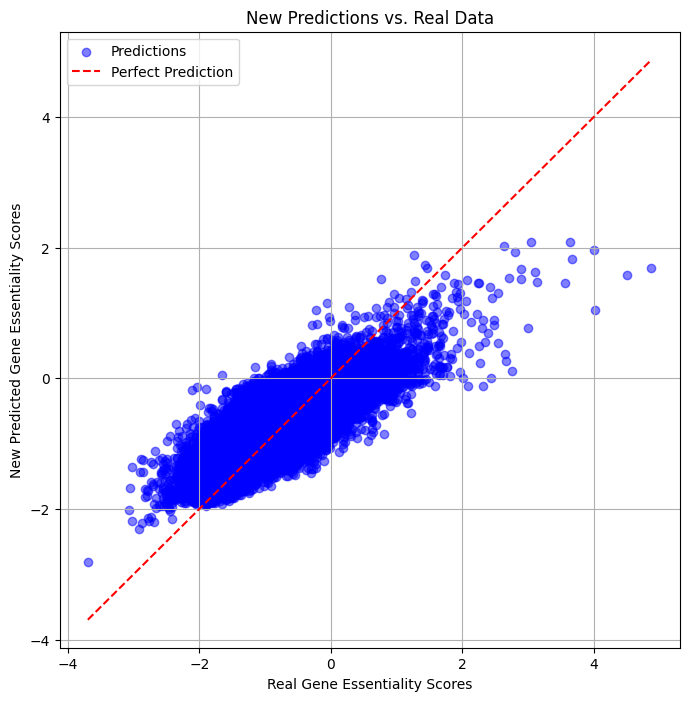

In [4]:
# Compare real and predicted data
def compute_metrics(real, predicted):
    mae = mean_absolute_error(real, predicted)
    mse = mean_squared_error(real, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(real, predicted)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2}

# Flatten the real and predicted arrays for metric calculations
real_values = real_depmap_subset_imputed.values.flatten()
predicted_values = predictions_EN_subset.values.flatten()

# Compute metrics
metrics = compute_metrics(real_values, predicted_values)
print("Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")
    
plt.figure(figsize=(8, 8))
plt.scatter(real_values, predicted_values, alpha=0.5, label="Predictions", color="blue")
plt.plot(
    [real_values.min(), real_values.max()],
    [real_values.min(), real_values.max()],
    color="red",
    linestyle="--",
    label="Perfect Prediction"
)
plt.xlabel("Real Gene Essentiality Scores")
plt.ylabel("New Predicted Gene Essentiality Scores")
plt.title("New Predictions vs. Real Data")
plt.legend()
plt.grid(True)
plt.show()

# plt.figure(figsize=(8, 6))
# sns.kdeplot(real_values, label="Real", color="green", fill=True, alpha=0.4)
# sns.kdeplot(predicted_values, label="Predicted", color="blue", fill=True, alpha=0.4)
# plt.title("Real vs Predicted")
# plt.legend()
# plt.grid(True)
# plt.show()

Performance Metrics:
MAE: 0.1719
MSE: 0.0493
RMSE: 0.2220
R²: 0.6473


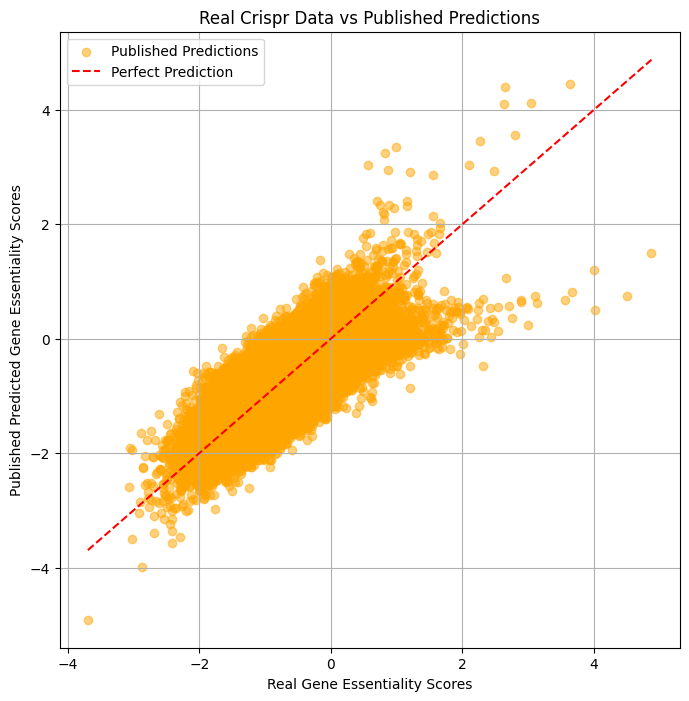

In [5]:
# compare real and published data
published_predicted_values = published_EN_subset.values.flatten()

# Compute metrics for the published model
metrics = compute_metrics(real_values, published_predicted_values)
print("Performance Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

plt.figure(figsize=(8, 8))
plt.scatter(real_values, published_predicted_values, alpha=0.5, label="Published Predictions", color="orange")
plt.plot(
    [real_values.min(), real_values.max()],
    [real_values.min(), real_values.max()],
    color="red",
    linestyle="--",
    label="Perfect Prediction"
)
plt.xlabel("Real Gene Essentiality Scores")
plt.ylabel("Published Predicted Gene Essentiality Scores")
plt.title("Real Crispr Data vs Published Predictions")
plt.legend()
plt.grid(True)
plt.show()

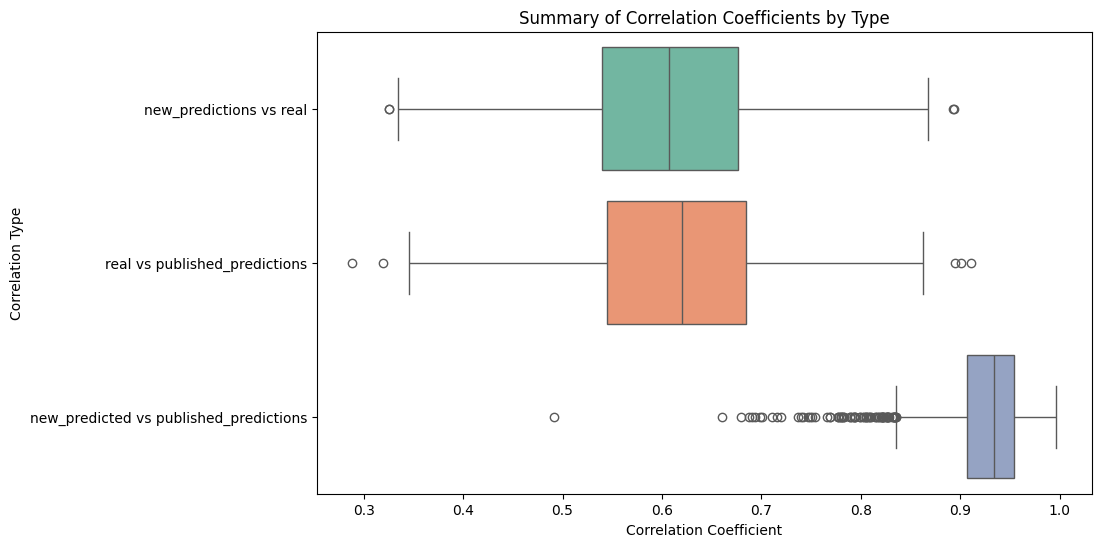

In [6]:
# calculate per gene correlations between as a measure of performance
predictions_EN_subset = predictions_EN_subset.transpose()
correlations = {}
for gene in common_genes:
    corr = {
        "new_predictions vs real": predictions_EN_subset[gene].corr(real_depmap_subset.loc[gene]),
        "real vs published_predictions": real_depmap_subset.loc[gene].corr(published_EN_subset.loc[gene]),
        "new_predicted vs published_predictions": predictions_EN_subset[gene].corr(published_EN_subset.loc[gene]),
    }
    correlations[gene] = corr

correlations_df = pd.DataFrame.from_dict(correlations, orient="index")
# print(correlations_df.head())

plt.figure(figsize=(10, 6))
sns.boxplot(data=correlations_df, orient="h", palette="Set2")
plt.title("Summary of Correlation Coefficients by Type")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Correlation Type")
plt.show()

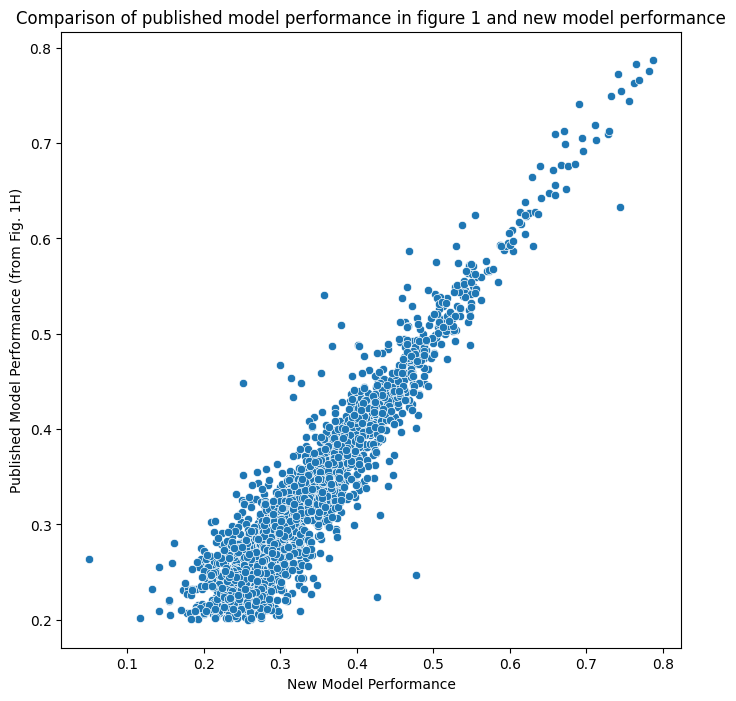

In [ ]:
# compare model performances from fig1 and new models

### create a scatter plot of new model performance vs the correlations_df freshly calculated correlations from real and published data ###
# load and clean
new_performances = pd.read_csv("output_data/model_performances_ccle_expression_only.csv")
new_performances = new_performances.rename(columns={'Unnamed: 0': 'model', 'x': 'performance'})

# Merge the DataFrames on the 'Models'/'model' column
merged_df = pd.merge(correlations_df, new_performances, left_index=True, right_on='model')

### create scatter plot of published model predictions and figure 1 model predictions ###
# load and clean
fig_1_performances = pd.read_csv("data/published_model_performance_figure1.csv")
fig_1_performances = fig_1_performances.drop(columns=['Multiomics.CV.cor'])

# Merge the DataFrames on the 'Models'/'model' column
merged_df = pd.merge(fig_1_performances, new_performances, left_on='Models', right_on='model')


### create scatter plot of model performance from figure 1 and the newly calculated model performance ###


# Create the scatter plot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=merged_df, x='performance', y='Expression.only.CV.cor')
plt.title("Comparison of published model performance in figure 1 and new model performance")
plt.xlabel("New Model Performance")
plt.ylabel("Published Model Performance (from Fig. 1H)")
plt.show()
###

### Filter to only include High Performing Models
In the cell below, n for the models is reduced to 1755 by filtering out the genes that do not meet the published threshold of 0.2 for performance (genes in the bottom left corner of above graph not included in app).

In [ ]:
# Make a list of all the models that have a new model performance of more than 0.2
passed_models = merged_df[merged_df['performance'] > 0.2]['Models'].tolist()

# get length of passed_models list
num_passed_models = len(passed_models)
print(num_passed_models)

# Create new directory if it does not exist
new_dir = "passed_0.2_threshold_1755_ccle_expression_only_models"
os.makedirs(new_dir, exist_ok=True)

# Define the existing directory containing all models
existing_model_dir = "models_ccle_expression_only/"

# Copy the models that have matching names from the existing directory to the new directory
for model_name in passed_models:
    # Define the source and destination file paths
    src_file = os.path.join(existing_model_dir, f"{model_name}_model.rds")
    dst_file = os.path.join(new_dir, f"{model_name}_model.rds")
    
    # Check if the source file exists before copying
    if os.path.exists(src_file):
        shutil.copy(src_file, dst_file)
        print(f"Copied {src_file} to {dst_file}")
    else:
        print(f"Model file {src_file} does not exist and cannot be copied.")

1755
Copied models_ccle_expression_only/AAMP_model.rds to passed_0.2_threshold_1755_ccle_expression_only_models/AAMP_model.rds
Copied models_ccle_expression_only/AARS2_model.rds to passed_0.2_threshold_1755_ccle_expression_only_models/AARS2_model.rds
Copied models_ccle_expression_only/AASDHPPT_model.rds to passed_0.2_threshold_1755_ccle_expression_only_models/AASDHPPT_model.rds
Copied models_ccle_expression_only/AATF_model.rds to passed_0.2_threshold_1755_ccle_expression_only_models/AATF_model.rds
Copied models_ccle_expression_only/ABCF1_model.rds to passed_0.2_threshold_1755_ccle_expression_only_models/ABCF1_model.rds
Copied models_ccle_expression_only/ABI1_model.rds to passed_0.2_threshold_1755_ccle_expression_only_models/ABI1_model.rds
Copied models_ccle_expression_only/ABT1_model.rds to passed_0.2_threshold_1755_ccle_expression_only_models/ABT1_model.rds
Copied models_ccle_expression_only/ACD_model.rds to passed_0.2_threshold_1755_ccle_expression_only_models/ACD_model.rds
Copied mo